# 基礎例題1: 映画レビューの二値分類("positive" or "negative")
## とりあえずデータ作成

In [29]:
import pandas as pd
from pathlib import Path

# ダミーデータ作成
data = {
    "review": [
        "The movie was fantastic! I really enjoyed it.",
        "Worst movie ever. I wasted two hours of my life.",
        "It was an okay film. Not great, but not terrible.",
        "Absolutely loved it! The best movie this year.",
        "Horrible acting and terrible plot. Do not recommend.",
        "A very touching story with excellent performances.",
        "The film was boring and way too long.",
        "Incredible cinematography and gripping story.",
        "Mediocre at best. I wouldn’t watch it again.",
        "Superb direction and great soundtrack. A must-watch!"
    ],
    "label": [1, 0, 1, 1, 0, 1, 0, 1, 0, 1]  # 1=Positive, 0=Negative
}

# データフレーム作成
df = pd.DataFrame(data)

# データ読み込み
data_dir = Path('/content/drive/MyDrive/Colab Notebooks/data')
# CSVとして保存
df.to_csv(data_dir / "movie_reviews.csv", index=False)
print("CSVファイルが作成されました。")

CSVファイルが作成されました。


# 本題の前に復習: 単語ベクトル化手法1
## TF-IDF(Term Frequency-Inverse Document Frequency)

  - TF: ある文書のなかに特定の単語がどれくらい登場するか--->目的の文書内での頻度
    - 文書1:「This is a great movie. The acting was fantastic.」
    - 文書2:「The movie was terrible. I will not recommend it.」
    - (文章1) movieの出現回数 = 1、文の全単語数 = 10、TF_1(movie) = 1 / 10
    - (文章2) movieの出現回数 = 1、文の全単語数 = 9、TF_2(movie) = 1 / 9

  - IDF: 特定の単語がすべての文書でどれくらい珍しいか--->文書間でのレア度
    - N: 文書の総数
    - d_t :単語tを含む文書数
    - IDF(t) = log(N/(1+d_t))
	- 「movie」は両方の文書に登場 →  IDF_1(movie) = log(2/(1+2)) ≒ -0.18
  - TF-IDF(t) = TF(t) \* IDF(t)
  - TF-IDF_1(movie) = 0.1 \* (-0.18) = -0.018
  - TF-IDF_2(movie) =  1 / 9 \* (-0.18) = -0.02


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

# サンプルデータ
df = pd.read_csv(data_dir / "movie_reviews.csv")
documents = df['review'].tolist()[:3]

# TF-IDFベクトル化
vectorizer = TfidfVectorizer(stop_words='english') # stop_words='english'：the, he, in, is, and など英語の一般的なストップワードが自動的に削除されます。
X = vectorizer.fit_transform(documents)

# 結果を確認
print(vectorizer.get_feature_names_out())
print(X.toarray())

['enjoyed' 'fantastic' 'film' 'great' 'hours' 'life' 'movie' 'okay'
 'really' 'terrible' 'wasted' 'worst']
[[0.52863461 0.52863461 0.         0.         0.         0.
  0.40204024 0.         0.52863461 0.         0.         0.        ]
 [0.         0.         0.         0.         0.46735098 0.46735098
  0.35543247 0.         0.         0.         0.46735098 0.46735098]
 [0.         0.         0.5        0.5        0.         0.
  0.         0.5        0.         0.5        0.         0.        ]]


# 基礎復習: 単語ベクトル化手法2
## 同じデータに対して今度はHuggingfaceからDistilBERTのトークナイザとエンコーダーをロードし、それを通じてトークンと埋め込みベクトルを得る

In [31]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# トークナイザとエンコーダーのロード
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint) #  uncased: 「大文字と小文字を区別しない」
encoder = AutoModel.from_pretrained(model_checkpoint)

# エンコーダーをフリーズ
for param in encoder.parameters():
    param.requires_grad = False

# テキスト達から埋め込みを得る関数
def get_bert_embeddings(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512) # paddingは短い場合に0埋めし固定長にする, truncationは、最大長を超えた場合に切り取り固定長にする。
    # print(f'{inputs=}')
    with torch.no_grad():
        outputs = encoder(**inputs) # outputs.shape = (バッチサイズ, シーケンス長, 各トークンの埋め込み次元)
    return outputs.last_hidden_state[:, 0, :].numpy() # シーケンスの0番目が[CLS] token


embeddings = get_bert_embeddings(documents)
print(embeddings)

[[ 0.13472511 -0.11771121  0.0577209  ... -0.07493205  0.39057425
   0.20153597]
 [ 0.0647999   0.00674988  0.04209154 ... -0.10047173  0.4034708
   0.1662673 ]
 [ 0.04829551 -0.16958712  0.05162412 ... -0.09341446  0.4102798
   0.2630738 ]]


# 本題: 映画レビューの二値分類("positive" or "negative")
手順概要
- module load
- CSVデータロード
- train, testに分ける
- DistilBERTによる埋め込みの生成
- ロジスティック回帰で分類器を構築
- 予測と評価
- 混同行列の可視化

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.50      1.00      0.67         1

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3



Text(0.5, 1.0, 'Confusion Matrix')

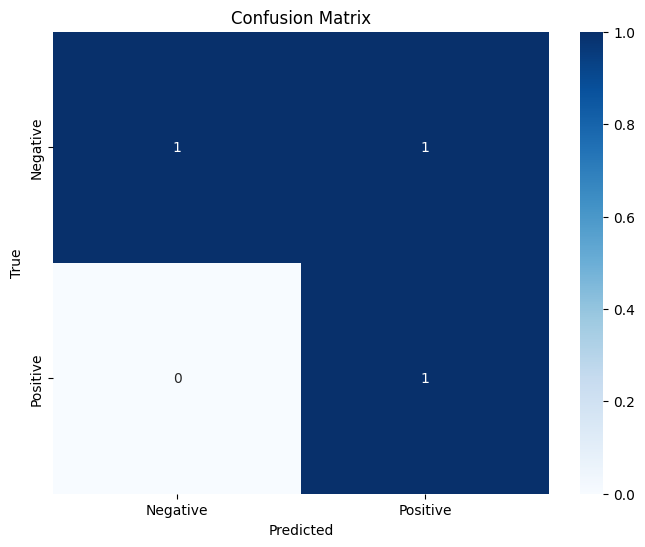

In [32]:
# module load
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# CSVファイルの読み込み
df = pd.read_csv( data_dir / "movie_reviews.csv")
# print(f'{df.head(3)}')

# データ分割
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['label'], test_size=0.3, random_state=0)

# 埋め込みの生成
X_train_embeddings = get_bert_embeddings(X_train.tolist()) # df -> python list
X_test_embeddings = get_bert_embeddings(X_test.tolist())

# ロジスティック回帰で分類器を構築
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_embeddings, y_train)

# 予測と評価
y_pred = clf.predict(X_test_embeddings)
print("Classification Report:\n", classification_report(y_test, y_pred))

# 混同行列の可視化
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# 基礎例題2: 単語の共起ネットワーク作成
ニュース記事やレビューのテキストから、単語の共起ネットワークを作成し、頻出する単語の関係を可視化します。

In [34]:
import pandas as pd

# ダミーデータの作成
data = {
    "text": [
        "The economy is recovering after the pandemic.",
        "The pandemic affected the global economy significantly.",
        "Technology companies are driving the economic recovery.",
        "Healthcare improvements are crucial after the pandemic.",
        "Global technology advances accelerate economic growth."
    ]
}

# CSVとして保存
df = pd.DataFrame(data)
df.to_csv(data_dir / "news_articles.csv", index=False)
print("ニュース記事データが作成されました。")

ニュース記事データが作成されました。


- コードの説明
  -	CountVectorizer を使って単語の出現回数をカウントします。
  -	単語同士の共起行列を作成し、NetworkXでネットワークとして可視化します。
  -	共起関係がある単語のみをエッジとして描画します。

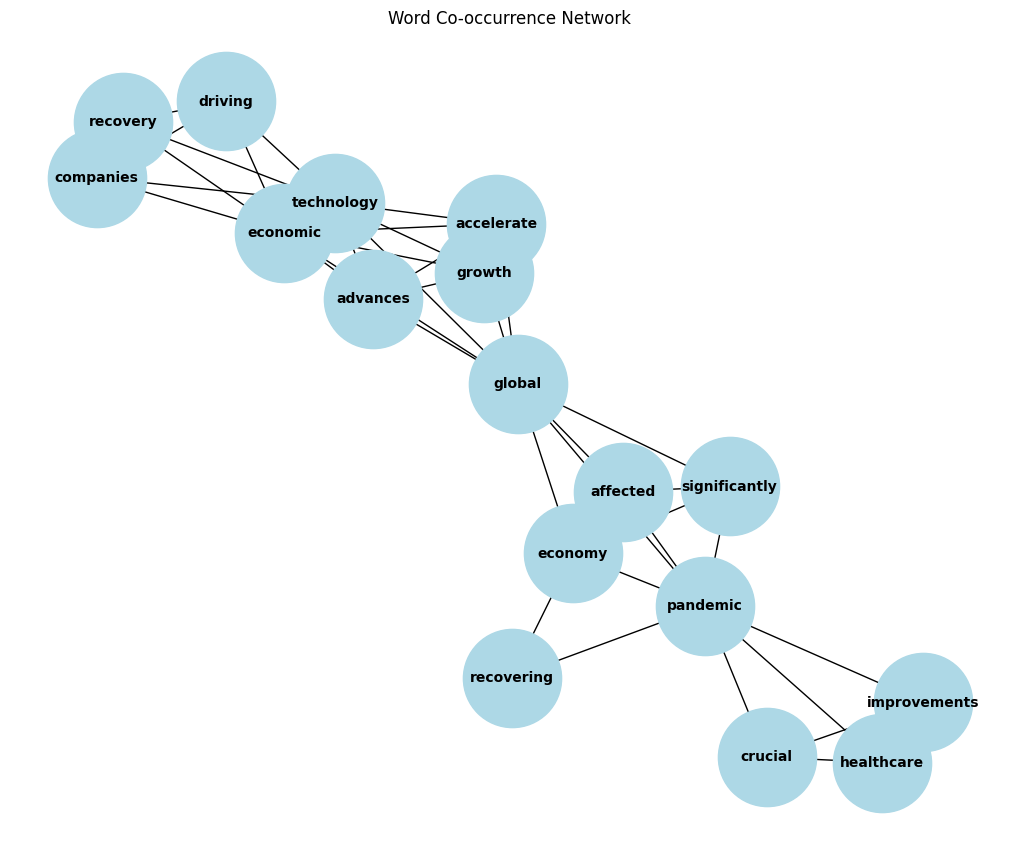

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
import matplotlib.pyplot as plt

# データ読み込み
df = pd.read_csv( data_dir / "news_articles.csv")

# 1. テキストのベクトル化（CountVectorizerで単語カウント）
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['text'])

# 2. 共起行列を作成
cooccurrence_matrix = (X.T @ X)  # 転置して行列積で共起行列
cooccurrence_matrix.setdiag(0)  # 対角成分は0にする（自己共起を防ぐ）

# 3. 単語リストを取得
words = vectorizer.get_feature_names_out()

# 4. NetworkXでネットワークを作成
G = nx.Graph()

# 5. ノードとエッジの追加
for i in range(len(words)):
    for j in range(i + 1, len(words)):
        if cooccurrence_matrix[i, j] >= 1:  # 共起回数が1以上ならエッジをつなぐ
            G.add_edge(words[i], words[j], weight=cooccurrence_matrix[i, j])

# 6. ネットワークの可視化
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # レイアウトの設定
nx.draw(G, pos, with_labels=True, node_size=5000, node_color="lightblue", font_size=10, font_weight="bold")
plt.title("Word Co-occurrence Network")
plt.show()